# 手把手带你从0开始写一个Transformer(自顶向下)

In [1]:
import os
import math
import copy

from IPython.display import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import numpy as np
import matplotlib.pyplot as plt


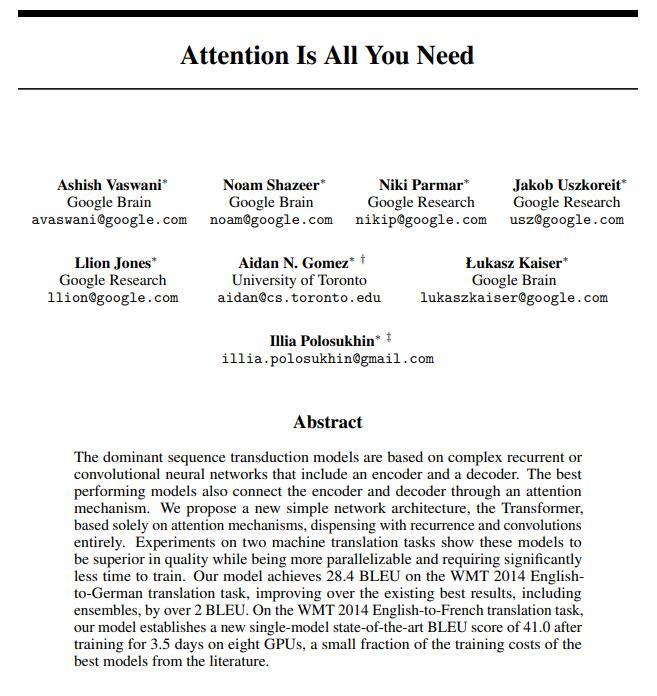

In [2]:
Image(filename='./images/transformer.jpg')

Transformer 一经提出，在NLP领域引起了巨大轰动，正如他的题目所言 "[Attention is all you need](https://arxiv.org/abs/1706.03762)", 这个工作完全摒弃了之前RNN等时序模型，完全使用注意力机制来进行序列建模。这个工作除了在机器翻译质量上面有了巨大的提升，并且为其他领域提供了一种新的完全基于注意力机制的结构，如随后发展起来的[BERT](https://arxiv.org/abs/1810.04805)，各种[BERT的变形和改进](https://arxiv.org/abs/2009.06732)，以及在视觉领域应用Transformer （"[A Survey on Visual Transformer](https://arxiv.org/abs/2012.12556)"）,论文写的很精彩和清晰，但是初次读论文的我们可能会对论文中的一些公式符号并不是很明白，导致很难将其正确的实现。

  因此在本文中，我将带领大家一步一步从0搭建一个完整的Transformer模型，我将从自底向上以及自顶向下两种方式来分别讲述如何实现和编码Transformer，讲述过程中论文中公式我会以截图给出方便说明，对于每一个类和函数我会尽量表达清楚他的输入输出以及向量维度。本文代码参考了哈佛[havardnlp](https://github.com/harvardnlp/annotated-transformer),对其做一个中文版的描述，方便大家学习。

## 1.背景和一些预先知识
本文中，我们以机器翻译的任务作为实际任务来完成transformer的构建，你需要大致了解机器翻译的架构以及一些pytorch的语法知识。这里我将会从自底向上的方式来讲述它，不过在这之前，我们需要明确我们的目标任务，我们的目标是做机器翻译，输入是一种语言的文本，输出是另一种语言的文本。（本文中以中英翻译举例子）

### 1.1预处理阶段
在预处理阶段，我们需要做的是两件事情，（1）构建我们的词典，（2）将我们的语料库切割成一句一句的对应。

#### 1.1.1构建词典：
这个过程比较简单，简单点你可以理解为，我们对整个语言的语料库进行分词，然后把所有分词的结果放入一个集合当中，那么我们就会得到一个字典，这个字典每一行代表一个分词的实体，具体来看一个公开的字典集合张这个样子：

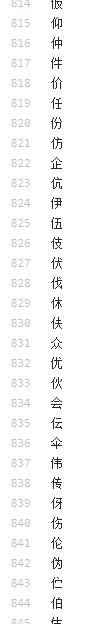

In [3]:
Image(filename='./images/google_zh.jpg')

这个字典构建好以后，我们就可以使用他的id来代表这个字，使得计算机可以理解和处理。还有一个问题，我们在训练过程中是一小批一小批数据来进行处理的，每一句的长短各不相同，但是向量处理又需要所有的样本保持对齐,因此，在字典中有一些特殊的符号来代表mask和pad以及一些其他的特殊符号。如下图的表示：

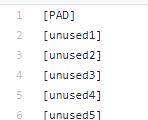

In [4]:
Image(filename='./images/pad.jpg')

#### 1.1.2 Tokenizer
字典建立完成后，我们就可以将输入转化为这样的一种id表示符号的输入，这个过程就是大家经常听到的Tokenizer的过程

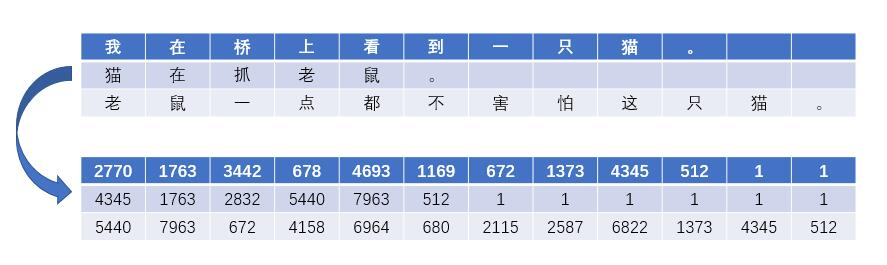

In [5]:
Image(filename='./images/dic.jpg')

到目前为止，我们知道了我们的输入如何用张量来表示$input\in \mathcal{R^{B\times L}}$,其中$B$就是代表我们的batchsize，$L$为每个样本的最大长度，不够最大长度的样本都用\[pad\]补全,字典来源于google_zh_vocab.txt

#### 1.2 结构
接下来就带大家自顶向下，从整体的encoder-decoder架构开始一步一步搭建起来下图这个结构。

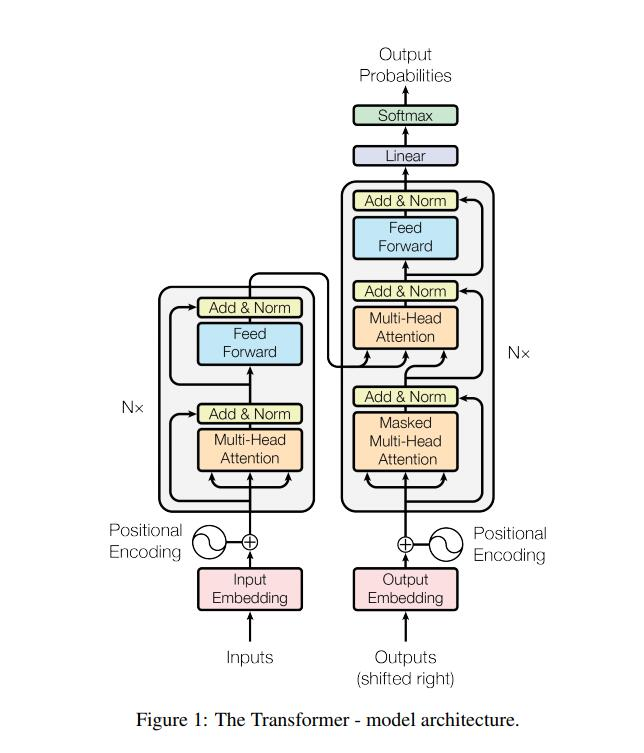

In [6]:
Image(filename='./images/arc.jpg')

## 2.Transformer
我们先从整体上来看这个架构，不用纠结细节，我们可以分为四个大块，input&output，encoder，decoder，generator四个部分，input&output负责输入和输出，encoder负责编码源语言的信息，decoder负责解码成为目标语言的信息，generator负责生成目标语言，这样一看这种架构是不是很清晰了。现在机器翻译的架构基本都是Encoder-Decoder结构，大部分都是在这个框架下来更改，Transformer也不例外，我们抓主要，先从大方向上来把握这个encoder-decoder结构，最后再来处理一些输入输出的细枝末节的东西


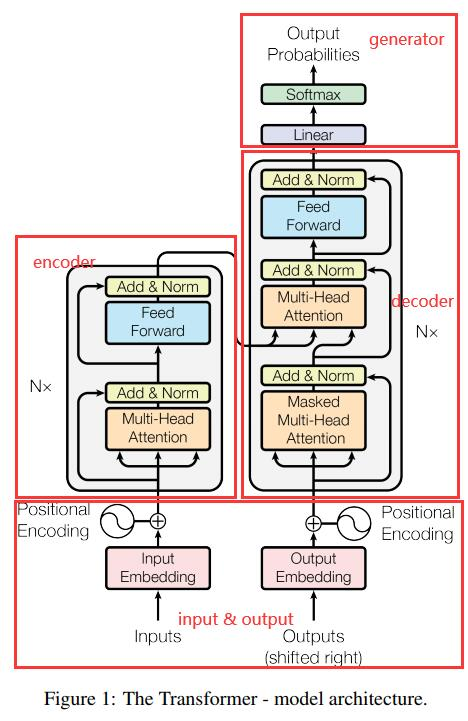

In [7]:
Image(filename='./images/arc2.jpg')

### 2.1 Encoder-Decoder
Encoder负责编码输入到一个隐空间，decoder将这个隐空间的表达解码，最终由generator来生成输出，我们先建立起来整体大局的观念！！！EncoderDecoder 顶层代码如下：
这里注意mask的操作，这是nlp里面常用的一个操作，为了使输入的信息不能过早的知晓未来的信息，会将未来的一些信息mask掉。

In [8]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, geneator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder          #编码器
        self.decoder = decoder          #解码器
        self.src_embed = src_embed      #源语言嵌入表达
        self.tgt_embed = tgt_embed      #目标语言嵌入表达
        self.geneator = geneator        #生成器
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decode(self.tgt_embed(tge), memory, src_mask, tgt_mask)
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encoder(src,src_mask), src_mask, tgt, tgt_mask) #将编码器的输出当作memory作为解码器的输入

#### 2.1.1 Generator
先把最简单的生成器说明一下，这个生成器其实就是一个线性映射，由于解码器解码出来的也是解码隐空间的表达，但是我们需要的输出是真真实实的目标语言，因此用一个线性映射加上一个softmax来得到最终人可以理解的输出。代码如下：

In [9]:
class Geneator(nn.Module):
    def __init__(self,d_model, vocab):
        super(Geneator, self).__init__()
        self.proj = nn.Linear(d_model,vocab)
    def forward(self, x):
        return F.log_softmax(self.proj(x),dim=-1)

解码器的输入$\mathcal{R^{B\times d_{model}}}$,也就是batchsize$\times$模型大小，生成器用一个线性映射到目标语言的词典大小，用softmax概率归一化输出就可以

#### 2.1.2 Encoder
这部分encoder编码器，可以将输入映射到一个隐空间，堆叠N层，不过在这之前，先来两个小插曲layernorm和clones。

>a.首先，介绍一下这个在Transformer中使用的LayerNorm，BatchNorm大家都熟悉，batchNorm做的是在一个batch中，将同一特征来归一化，LayerNorm做的是什么呢，LayerNorm做的是在一个样本中，对所有的特征来归一化，听着有点玄乎，看看下面这个图就明白啦：
还不明白的话大家可以去看看知乎这个链接，讲的很明白[layer Normalization][https://zhuanlan.zhihu.com/p/54530247]，代码如下：


In [33]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self, x):
        mean = x.meax(-1, keepdim=True)
        std  = x.std(-1, keepdim=True)
        return self.a_2*(x - mean)/(std+self.eps) + self.b_2

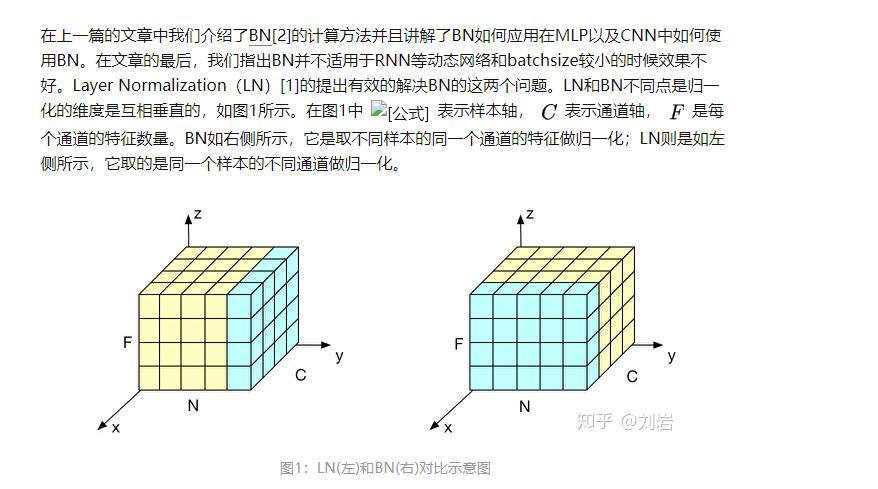

In [10]:
Image(filename='./images/bn.jpg')

>b. clones完全是为了我们在实现的时候，少写重复代码，比如encoder重复N次，decoder重复n次之类的代码，做了一个辅助函数，他张下面这个样子：很简单，后面代码看到clones这个函数的时候，知道他是什么意思就可以啦！！

In [11]:
def clones(moudle, N):
    "produce N indentical laysers"
    return nn.ModuleList([copy.deepcopy(moudle) for _ in range(N)])

有了这两个辅助工具和函数，我们就可以先从框架上将Encoder构建起来，我们把内部的所有功能都继承到Encoderlayer中，然后堆叠N层，每一层输出后跟随一个LayerNorm，具体实现如下：

In [12]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

这里面的layer，我们将其抽象为EncoderLayer专门构建，接下来来实现这个EncoderLayer，我们发现EncoderLayer中，有两个很相似的结构，每一个都类似一个残差链接，我们抽象出一个SublayerConnection，那么EncoderLayer的实现就是这两个子模块的叠加啦~~~代码如下

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_atten, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_atten #下面的attenton 部分
        self.feed_forward = feed_forward #上面的 feed forward部分
        self.sublayer = clones(SublayerConnection(size, dropout),2)
        # 两个链接模块一上一下，每一个sublayer输入为（x，corelayer）
        self.size = size
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,mask))#下部分
        return self.sublayer[1](x, self.feed_forward)#上部分

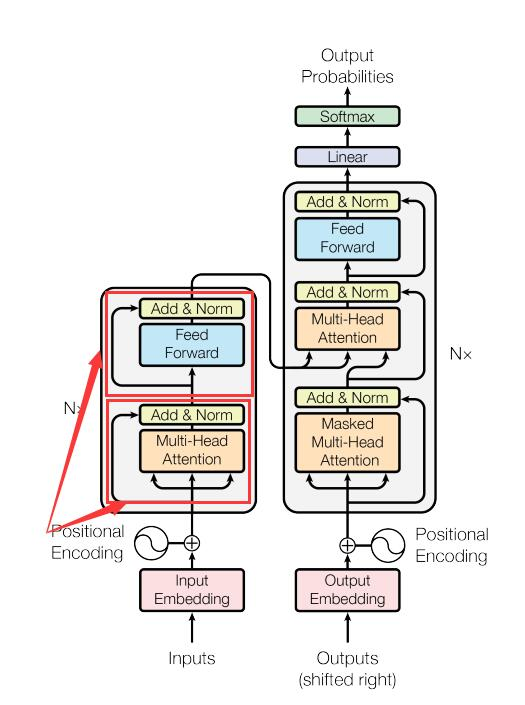

In [14]:
Image(filename='./images/submoudle.jpg')

In [15]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

其中sublayer的内容就是Feedforward或者multi-head Attention这两个模块，将其抽象为一个sublayer，对输入进行layerNorm然后通过sublayer功能模块，最后再进行残差链接。到目前为止，我们Encoder就剩两个功能模块还未完成，一个是Feed forward，另一个是transformer的核心结构multi-head attention，我们一一来讲述；
#### Feed Forward

这个模块包含两个线性变换函数和一个ReLU激活函数，就是一个MLP，中间隐藏层神经元个数为$d_{ff}=2048$,输入层和输出层神经元个数为$d_{model}$
论文中公式如下：
$$
FFN(x)=max(0,xW_1x+b_1)W_2+b_2
$$
其中，$W_1\in \mathcal{R^{d_{model}\times d_{ff}}},W_2\in \mathcal{R^{d_{ff}\times d_{model}}}$,代码实现很简单，输出的维度和输入一致也是$\mathcal{R^{B\times L\times d_{model}}}$,这样就可以和multiheadattention的输出可以相加合并了

In [16]:
class PositionwiseFeedForward(nn.Module):
    "implements FFN equation"
    def __init__(self, d_model, d_ff, dropout = 0.1):
        super(PositionwiseFeedForward,self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

MultiHead-Attention

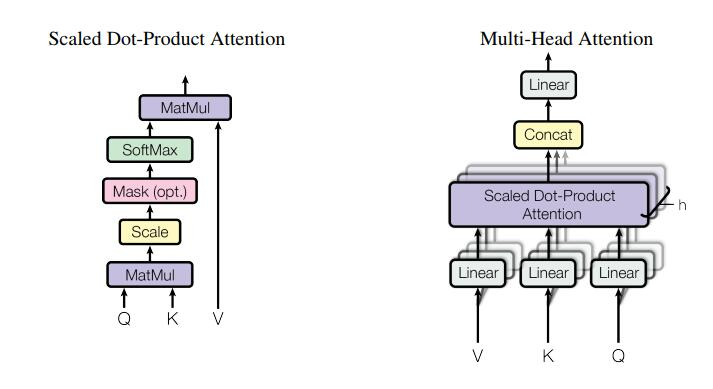

In [17]:
Image(filename='./images/multi.jpg')

我们先来看看单头的注意力，单头注意力机制也就是论文里面的Scaled Dot-Product Attention这一小节，公式表达很简单$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$, 关于这个公式的理解，大家可以参考李宏毅老师的课程，讲的很通俗易懂([B站链接][https://www.bilibili.com/video/BV1J441137V6?from=search&seid=6165482609208740814]), 简单来讲就是每个token都映射成为三个分量query, key, value,然后使用每个query去与其他以及自己的key做相似度计算，也就是attention系数，最后使用这些注意力系数与value的加权结果来更新embedding。

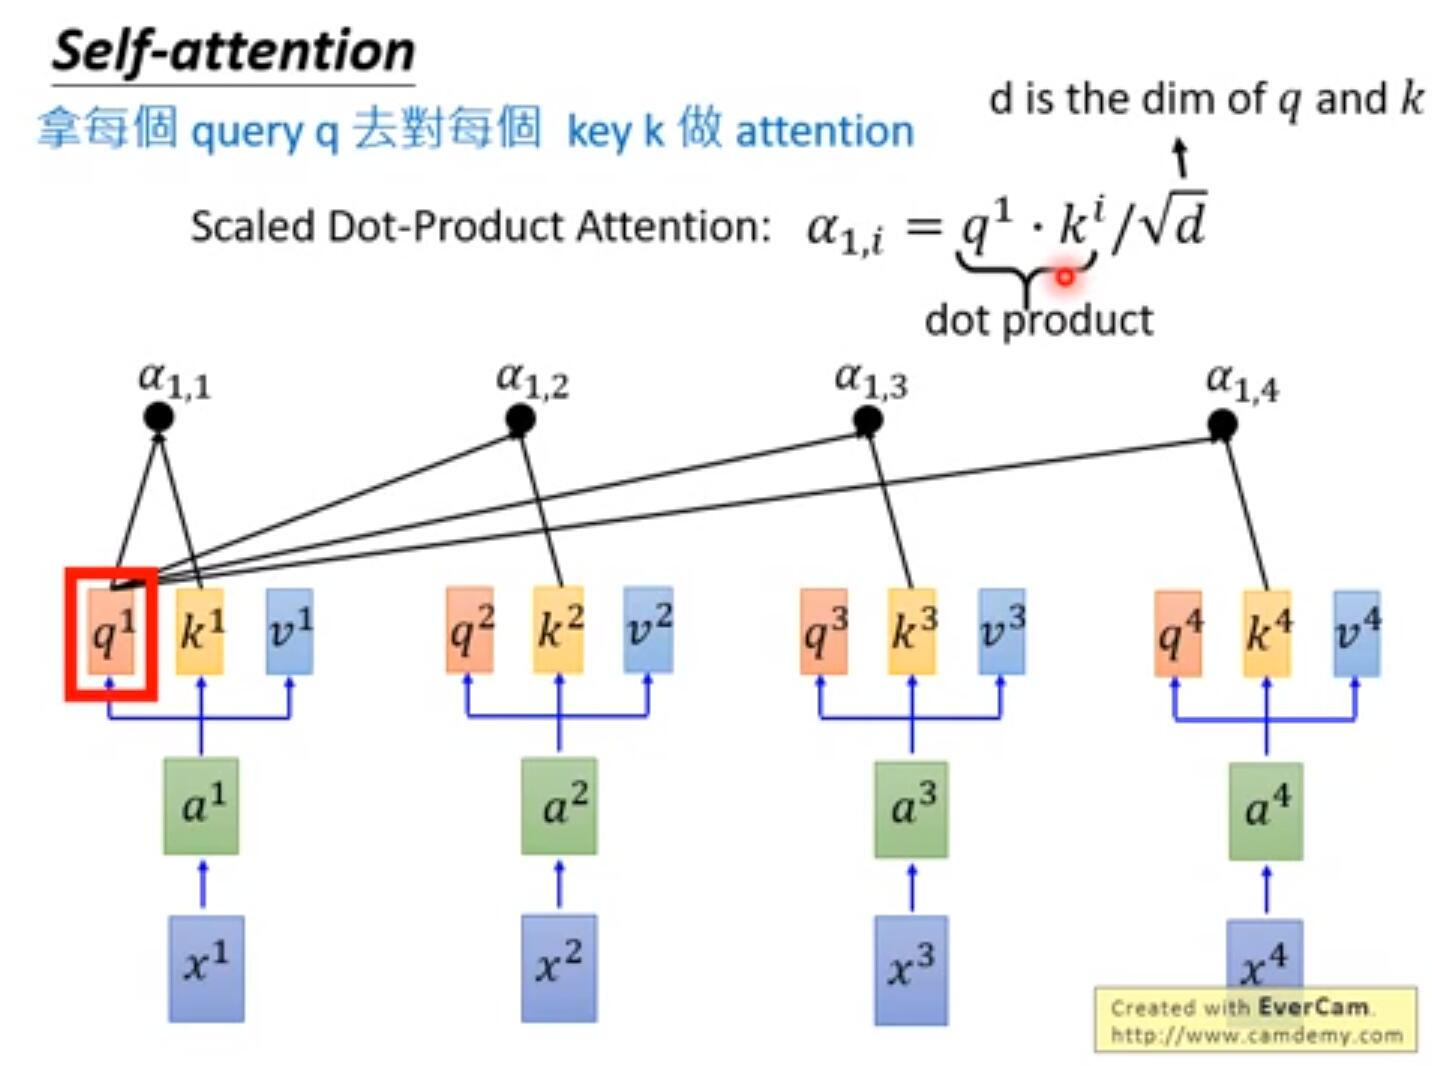

In [18]:
Image(filename='./images/sa.jpg')

In [19]:
def attention(query, key, value, mask = None, dropout = None):
    """
    Conpute Scaled Dot Product Attention softmax(QK'T/sqrt(dk))*V
    """
    d_k = query.size(-1)
    scores = torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask==0,-1e9)
    p_att = F.softmax(score,dim = -1)
    if dropout is not None:
        p_att = dropout(p_att)
    return torch.matmul(scores, value),p_att

上面代码就实现了Attention的计算方式使用$QK^T$的结果就是一个Attention map，然后对其做softmax概率归一化得到了Attendion的系数，最后与Value做线性加权，得到最终的结果，这里我们需要注意两个点（1）是这里的mask，mask是为了防止提前引入未来的信息，（2）是这个$\sqrt{d_k}$的作用，原文是这样解释的：

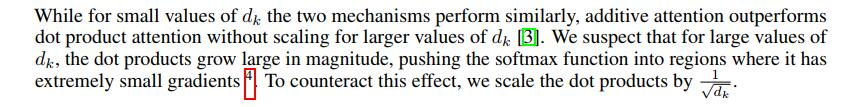

In [20]:
Image(filename='./images/dk.jpg')

这里我换个角度来解释一下这个原因，除以$\sqrt{d_k}$这个操作我们可以看作是一个归一化的操作，这是对Attentionmap里面的元素进行操作，这个元素是由$q,k$的点积来得到的，在没有任何先验知识的情况下，我们只能假设这些$q,k$服从于正态分布，我们来推导一下结果。

假设$q=[q_1,q_2,...q_{d_k}],k=[k_1,k_2,...,k_{d_k}]$,我们事先并不知道$q,k$的先验知识，假设他们服从正态分布,并且都互相独立，即$q_i,k_i \sim \mathcal{N}(0,1),i=1,2,...,{d_k}$,$a = \sum_{i=1}^{{d_k}}q_ik_i$，我们来看看$a$的期望和方差。

期望：
$$
E(a)=E(\sum_{i=1}^{d_k}q_ik_i)=\sum_{i=1}^{d_k}E(q_i)E(k_i)=0
$$

方差：
$$
D(a)=D(\sum_{i=1}^{d_k}q_ik_i)=\sum_{i=1}^{d_k}D(q_i)D(k_i)=d_k
$$。
因此$a\sim\mathcal{N}(0,d_k)$,对$a$标准化一下那就是$\frac{a-0}{\sqrt{d_k}}$,这就是除以$\sqrt{d_k}$的由来。就是论文注释的内容。

经历过输入经历过Attention后我们的输出维度和输入是保持一致的依旧是$\mathcal{R}^{B\times L\times d_k}$

单头明白了，多头也就很容易啦，不过这里我特别想说明的是，这个多头注意力并不是在同一个数据上重复n次然后拼接结果，我刚开始看这个图的时候，错误的理解了原文的意思，导致一直没有想明白,可以看看下面这个图就明白了，每个头其实负责的是不同子空间的注意力。

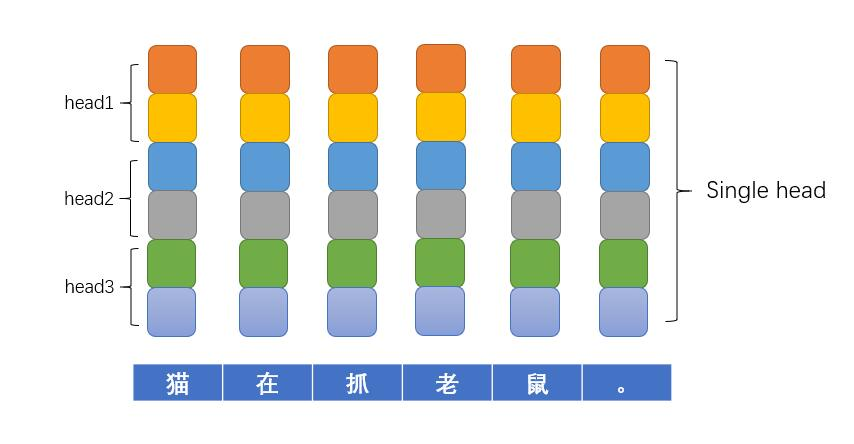

In [21]:
Image(filename='./images/sinmul.jpg')

左边描述了multihead的情况，右边是singlehead，这也就解释了$n\_head*d_k==d_{model}$,可能刚接触transformer的人在使用transforemer包的时候会遇到这个疑惑。
multihead attention的核心公式：
$$
MultiHead(Q,K,V) = Concat(head_1,head_2,...,head_h)W^O
$$
$$
head_i = Attention(QW_i^Q,KW_i^Q,VW_i^V)
$$
其中$W$都属于模型参数部分，$W_i^O\in \mathcal{R^{d_{model}\times d_k}},W_i^K\in \mathcal{R^{d_{model}\times d_k}},W_i^V\in \mathcal{R^{d_{model}\times d_v}},W_O\in \mathcal{R^{hd_v\times d_{model}}}$,在代码实现中$d_k=d_v=d_{model}/h$

In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout = 0.1):
        "h : # of heads, d_model: dim of input"
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        # assume d_v == d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model,d_model),4)
        self.attn = None
        self.dropout = nn.Dropout(p = dropout)
    def forward(self, query, key, value, mask = None):
        "implements multi head attention"
        if mask is not None:
            mask = mask.unsqueeze(1)#applied to all h heads
        nbatches = query.size(0)
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches,-1, self.h, self.d_k) for l,x in zip(self.linears, (query, key, value))]
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask = mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1,2).contiguous().view(nbatches, -1, self.h*self.d_k)
        return self.linears[-1](x)#out projection

到此为止，我们完成Encoder部分的构建。

#### 2.1.3 Decoder
Decoder和Encoder的结构略有差别，只不过我们的基础组件都写好了，剩下就是搭积木的事情啦，我们实现的是下面这个结构。我们思路还是一致，先自顶向下构建encoder，将EncoderLayer堆叠N层，具体实现如下：


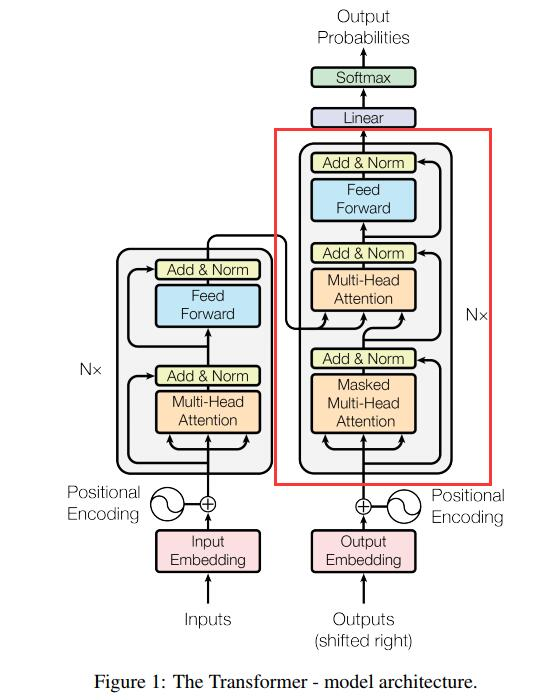

In [23]:
Image(filename='./images/decoder.jpg')

In [35]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [36]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout),3)
    def forward(self,x, memory, src_mask, tgt_mask):
        m = memory
        #最下层的 multi-head attention 和encoder的结构一样，对目标语言做attention
        x = self.sublayer[0](x, lambda x:self.self_attn(x,x,x,tgt_mask))
        #中间那层的multi-head attention decoder 的输出作为query ，去和encoder的 输出memery 作为key和value
        x = self.sublayer[0](x, lambda x:self.src_attn(x,m,m,src_mask))
        #最上层的sublayer ：PositionalEncoding
        return self.sublayer[2](x, self.feed_forward)

注释详细解释了代码，到目前为止整个transformer已经构建完成了，剩下的就是一些输入输出的尾巴处理。

### 2.2 input&output
### 2.2.1 EmbeddingLayer
第一节讲解了输入的形式，输出的形式也大同小异，$input$和输出$output$他们表示都是一致的，从Transformer结构图中，我们可以看出首先经过的就是一个Embedding层，这一层就是将我们输入的每一个id用一个向量来表示，最经典的方法是word2vec，讲大白话就是一个查表的过程，看看id是多少，然后把那个向量取出来。


In [38]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.lut(x) *math.sqrt(self.d_model)

上述就是Embedding层的具体是实现。其中$d_model$就是表示每一个id所取出来的向量的大小，$vocab$表示的是我们的字典的大小，也就是字典的容量。数学表达看就是$self.lut\in \mathcal{R^{vocab\times d_{model}}}$, 经过这一层后，输入输出就可以增加一个维度，原始的$inputs,outputs\in \mathcal{R^{B\times L}}$ ，$Embinputs =Embedding(inputs),Emboutputs =Embedding(outputs)$ ,经过embedding层后的输出维度为$Embinputs,Emboutputs\in \mathcal{R^{B\times L\times d_{model}}}$。到目前，我们已经实现了整个transformer的以下部分

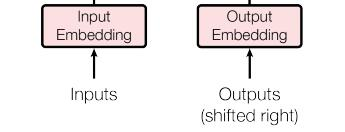

In [25]:
Image(filename='./images/emb.jpg')

### 2.2 PositionalEmbedding
接下来我们来看看Embedding层上面的PositionalEmbedding层是怎样的，因为Transformer完全抛弃了RNN这种序列行为建模的方式，完全使用Attention机制来实现，但是序列信息对于文本这样天然的序列信息是尤为重要的，因此在Transformer中加入了位置编码信息。论文中是这样介绍这个模块的：

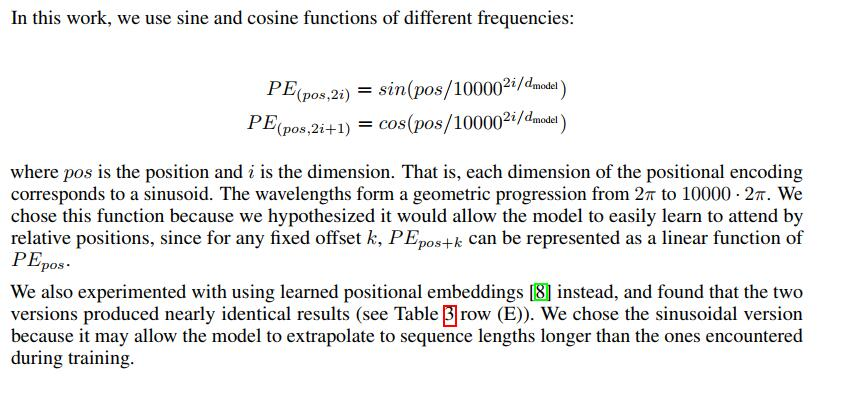

In [26]:
Image(filename='./images/pos.jpg')

In [ ]:
Image(filename='./images/posex.jpg')

这段话什么意思呢？说白了就是transformer建模的时候没有考虑token与token之间的序列行为，而这个序列行为对于文本来说又很重要，所以他们提出了一种位置编码的方法，创建了一个与原始样本embedding维度大小一致的位置embedding，然后把这两玩意儿加起来，就算是把序列信息融入进去了。具体来说就是，使用三角函数来对不同位置的频率编码，下图说的比较明白：

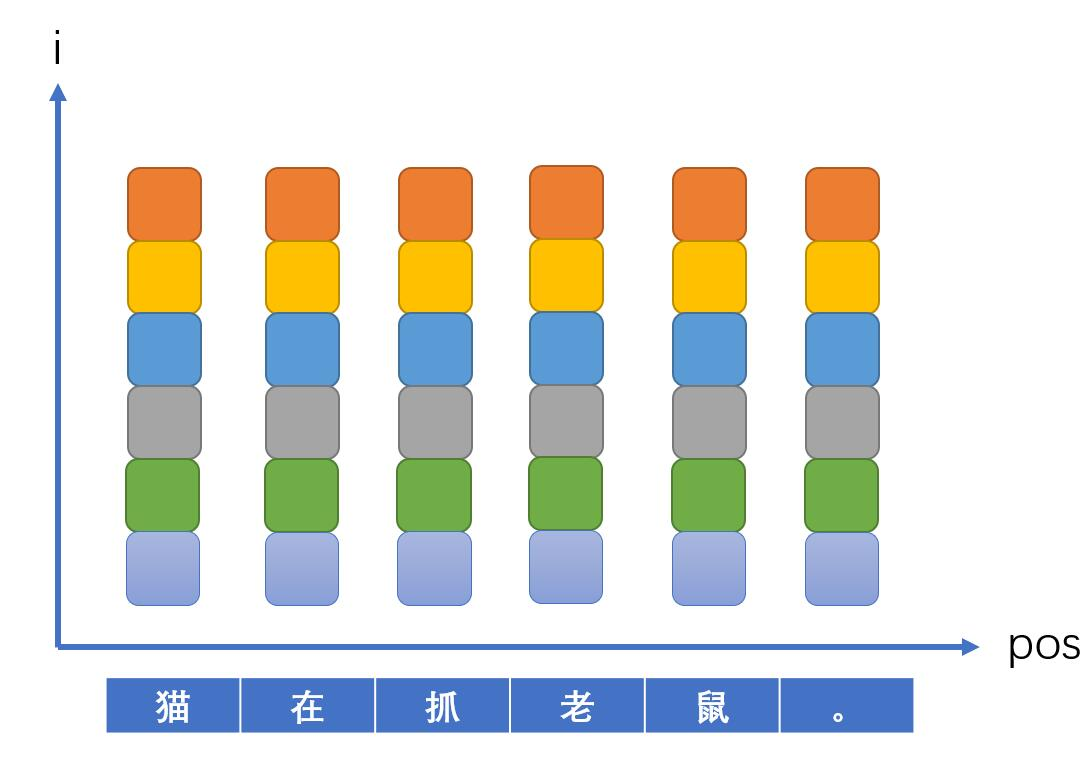

In [27]:
Image(filename='./images/posex.jpg')

上图为一个例子，横向为pos位置纵向为维度的位置，对于$i$为奇数的话，使用sin函数，$i$为偶数使用cos函数,也就是上面公式所表达的样子，我们具体来看看代码如何实现。

In [29]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model) #创建全0的位置来稍后填充
        position = torch.arange(0,max_len).unsqueeze(1)#构建从1到maxlen的递增序列，三角函数里面的分子
        div_term = torch.exp(torch.arange(0,d_model,2)*-(math.log(10000.0)/d_model))#三角函数的分母
        pe[:, 0::2] = torch.sin(position*div_term)#计算所有位置的sin
        pe[:, 1::2] = torch.cos(position*div_term)#计算所有位置的cos
        pe = pe.unsqueeze(0)#将pe升维到3维空间，第一维度对应于batch，这样可以最后相加
        self.register_buffer("pe",pe)
    def forward(self, x):
        x = x + Variable(self.pe[:,:x.size(1)],requires_grad=False)#取输入所需要长度的位置编码就可以
        return self.dropout(x)

d_model是向量维度的最大值，max_len是pos的最大值，实现细节为了代码简单，先把sin，cos所有位置的都算出来，然后根据奇偶来各取所需，这个模块是一个固定的参数，所以不需要梯度回传与更新。下面简单看一个例子就更加明白了：

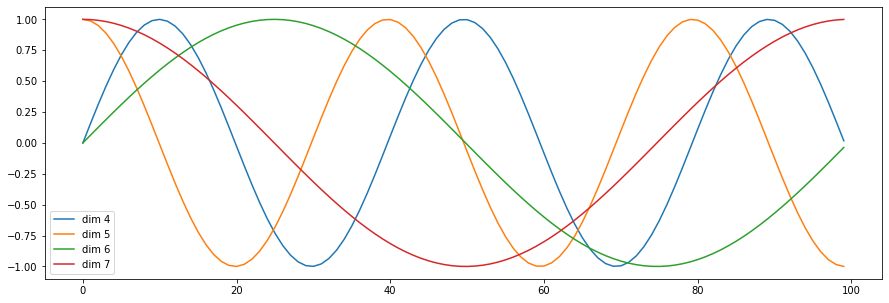

In [30]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)#每一个token的embedding长度为20
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

#### 2.3 make transformer
最后我们来一起实例化一个transformer

In [39]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "construct a model from hyperparameters"
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Geneator(d_model, tgt_vocab)
    )

    ## This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [40]:
tmp_model = make_model(10, 10, 2)

## 3. Training 测试